Use KD-tree to find the nearest neighbour.

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Then, we need to define a square. There are a lot of ways we can define a square. Here, we will just use the center (just a point) and its distance form the boundary of the square. 

In [2]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)

        self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 

    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True

In [8]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,capacity,max_depth=5,depth=0):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.
        
        capacity: how many points it can hold. If there are more points inside this cube, then
        subdivide it.
        
        max_depth: number of allowed subdivisions
        
        depth: depth of current node
        
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
        
        self.boundary=boundary
        self.capacity=capacity
        self.max_depth=max_depth
        self.depth=depth
        
        self.points=[] #list of intances of Point. The points inside the cube.
        self.number_of_points=0
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
                        
                        
    def subdivide(self):
        '''Subdivide the cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.signs[i][d]*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            
            self.children[i]=DTree(child,self.capacity,self.max_depth,self.depth+1)
        
    
    def push(self,point):
        '''
        Add point in points.
        if the number of points exceeds self.capacity, subdivide.
        
        Returns True if the point is accepted and False if it is not
        '''
        
        #if this point is not inside the boundary, do nothing
        if not self.boundary.check_point(point):
            return False
        
        if self.number_of_points < self.capacity or self.depth==self.max_depth:
            self.points.append(point)
            self.number_of_points+=1
            
        else:
            '''if it already has children, do not subdivide'''
            if not self.has_children:
                self.subdivide()#subdivide the cube
                
                #fill the childern with all the points of this DTree 
                for p in self.points:
                    for ch in self.children:
                        if ch.push(p):
                            break#if the point is accepted in this child, then go to the next point
                
                self.points=[]#empty this list

                
                
            for ch in self.children:
                if ch.push(point):
                    break
        
        return True
        
        
    def locate(self,point):
        '''
        Find in which sub-tree the point lies
        point: a point inside the unit cube.
        '''
        if not self.boundary.check_point(point):
            #if the point is outside of this cube, it will not be inside any of its sub-trees
            return False,self
        
        if self.boundary.check_point(point):
            if not self.has_children:
                #if the point is inside this cube and this is the deepest node, we have found it!
                return True,self
            
            #The point will be in *exactly* one of the children.
            #So, once locate returns True, stop looking for it.
            if self.has_children:
                for ch in self.children:
                    check,tree=ch.locate(point)
                    if check:
                        return check,tree
        
        
        
        
        
        
        
        
    def distance(self,point1,point2):
        r=0
        for d in range(self.dim):
            r+=(point1[d]-point2[d])**2
        return r**0.5
        
        
    def _nearest_(self,point):
        '''naive way to find the nearest'''
        points=self.get_points()
        if len(points)==0:
            return []
        
        nearest=points[0]
        r_min=self.distance(nearest,point)
        for p in points[1:]:
            r=self.distance(point,p)
            if r<r_min:
                r_min=r
                nearest=p
        return nearest
            
    
    def _nearest(self,point):
        '''
        Get the nearest point in the tree. This is not the optimal method. This checks all the points!
        Slower even than the naive one!
        *I did it to sharpen my recursion skills.*
        
        point: the point whose nearest we need
        '''
        #if there is no point inside return False. 
        if self.number_of_points==0:
            return False, []

        if self.number_of_points>0:
            if not self.has_children:
                nearest=self.points[0]
                r_min=self.distance(point,nearest)
                for p in self.points[1:]:
                    r=self.distance(point,p)
                    if r<r_min:
                        r_min=r
                        nearest=p
                return True, nearest    


            if self.has_children:
                candidates=[]
                for ch in self.children:
                    if ch.number_of_points==0:
                        continue
                    else: 
                        _=ch._nearest(point)
                        if _[0]:
                            candidates.append(_[1])
                if len(candidates)==0:
                    return False, []


                nearest=candidates[0]
                r_min=self.distance(point,nearest)
                for p in candidates[1:]:
                    r=self.distance(point,p)
                    if r<r_min:
                        r_min=r
                        nearest=p
                return True,nearest    
                    
        
        
        
    def get_points(self):
        '''Get the points of the tree and its children  recursively'''
        if self.has_children:
            points=[]
            for i in self.children:
                for p in i.get_points():
                    points.append(p)
            return points
        else:
            return self.points
        
        
        
        
    def get_cubes(self):
        '''Get the cubes of the tree and its children  recursively'''
        cubes=[self.boundary]
        if self.has_children:
            for i in self.children:
                for c in i.get_cubes():
                    cubes.append(c)
        return cubes

    def get_centers(self):
        '''Get the centers of the tree and its children  recursively'''
        centers=[self.boundary.center]
        if self.has_children:
            for i in self.children:
                for c in i.get_centers():
                    centers.append(c)
        return centers
    
    



You can make 2 dimensional objects

In [59]:
Qt=DTree(Cube([0.5,0.5],0.5),100,50)

In [60]:
for _ in range(5000):
    cov = np.array([[0.1, 0.01], [0.01, 0.01]])
    r=np.random.multivariate_normal([0.5, 0.5], cov)

    Qt.push(r)

In [63]:
Qt.locate([0.3,1])[1]

<IPython.core.display.Javascript object>


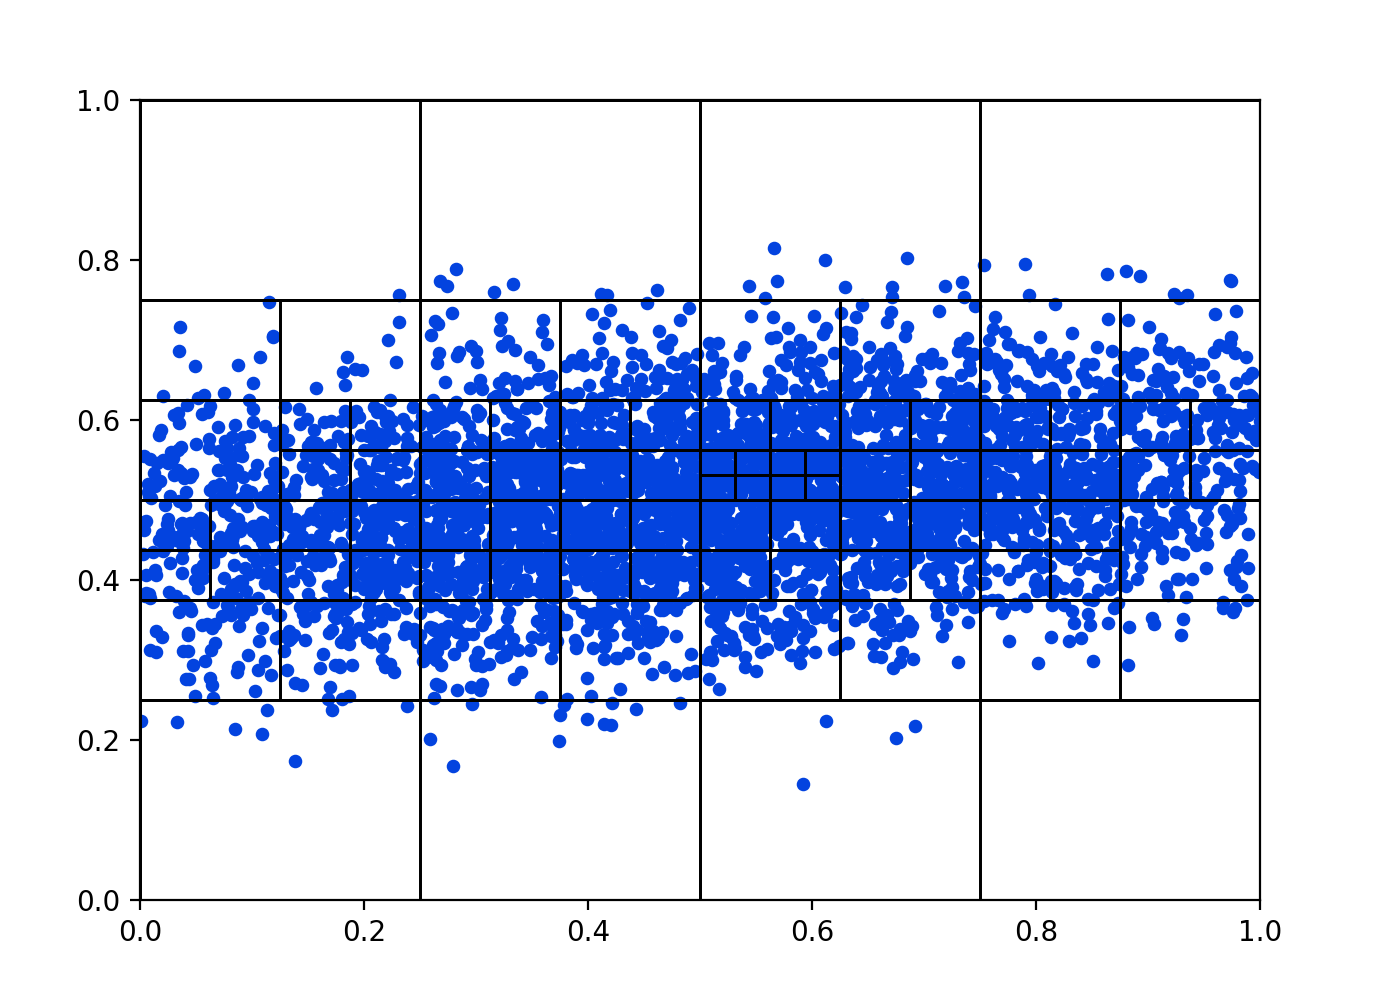

In [62]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

# cc=np.array(Qt.get_centers())
# sub.scatter(cc[:,0],cc[:,1],c='xkcd:black',s=15)
pp=np.array(Qt.get_points())
sub.scatter(pp[:,0],pp[:,1],c='xkcd:blue',s=15)


sq=np.array(Qt.get_cubes())
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[1]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )




sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()

You can make 1 dimensional objects